# Dataset

In this notebook, we are exploring the dataset used for the vehicle localization assigment. The provided files are in the Point Cloud Data (PCD) format, which are crucial for processing and visualizing spatial data in autonomous vehicle technology.

## Files Included

- **map.pcd:** This file represents the map where the vehicle needs to localize itself.
- **frames/frames_\<n\>.pcd:** This directory contains sequential frames from 0 to 1013, capturing different moments and perspectives of the vehicle's journey inside the CARLA simulator.
- **ground_truth:** This file contains the exact vehicle positions in meters and orientations in radians for each frame from 0 to 1013. It serves as a reference to evaluate the vehicle's localization accuracy.

## Ground Truth Analysis

### Load ground truth values

To handle and visualize the ground truth data efficiently, we will use various Python libraries. These libraries will help in loading, processing, and plotting the data for better analysis.

In [49]:
import os

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import pandas as pd

from pypcd4 import PointCloud
from scipy.spatial.transform import Rotation
from typing import List, Tuple


# Load ground truths
gts = pd.read_csv("./dataset/ground_truth.csv")

# Print gt
print(gts)

      Frame        x        y         z      roll     pitch       yaw
0         0    0.000  0.00000  0.000000  0.000000  0.000000  0.000000
1         1    0.000  0.00000  0.015636  0.000000  0.000000  0.000000
2         2    0.000  0.00000  0.005846  0.000000  0.000000  0.000000
3         3    0.000  0.00000  0.005628  0.000000  0.000000  0.000000
4         4    0.000  0.00000  0.005628  0.000000  0.000000  0.000000
...     ...      ...      ...       ...       ...       ...       ...
1009   1009  182.299  5.29271 -0.018730 -0.029093 -0.014225  0.019378
1010   1010  182.299  5.27850 -0.023267 -0.030727 -0.015000  0.019204
1011   1011  182.299  5.28007 -0.014406 -0.028470 -0.012781  0.019203
1012   1012  182.299  5.27980 -0.023047 -0.035554 -0.017184  0.019364
1013   1013  182.299  5.28085 -0.024493 -0.030387       NaN       NaN

[1014 rows x 7 columns]


You can easily retrieve the vehicle's position and orientation using pandas with the following approach:

In [50]:

# Get position and orientation for a specific frame
FRAME = 50
gt = gts.iloc[FRAME]

# Extract the row and use direct slicing to create numpy arrays
gt = gts.iloc[FRAME]
pos = gt[['x', 'y', 'z']].to_numpy()
orientation = gt[['roll', 'pitch', 'yaw']].to_numpy()

# Print position and orientation arrays
print(f"Position: {pos}")
print(f"Orientation: {orientation}")


Position: [4.28331    0.0609112  0.00704979]
Orientation: [-4.26106e-06 -8.84533e-05  4.61252e-04]


#### Calculate error

For this assigment you need to calculate the error between the localization and the ground truth values. You can calculate two types of errors by comparing the ground truth data with estimated values:

1. **Lateral Error**: Measures the deviation between the ground truth and estimated positions in the XY plane.
   
2. **Yaw Angle Error**: Determines the difference between the ground truth and estimated orientations in the yaw angle.

The following function computes these errors given ground truth and estimated positions/orientations:

In [72]:
def calc_error(gt_position: np.ndarray, gt_orientation: List[float], estimated_position: np.ndarray, estimated_orientation: np.ndarray) -> Tuple[float, float]:
    """
    Calculates lateral error and yaw angle error based on ground truth and estimated values.

    Args:
    - gt_position (np.ndarray): Ground truth displacements in [x, y, z] format.
    - gt_orientation (List[float]): Ground truth angles in [roll, pitch, yaw] format.
    - estimated_position (np.ndarray): Estimated displacements in [x, y, z] format.
    - estimated_orientation (np.ndarray): Estimated angles in [roll, pitch, yaw] format.

    Returns:
    - Tuple[float, float]: Lateral error in meters and yaw angle error in degrees.
    """
    if not (gt_position.shape == (3,) and estimated_position.shape == (3,)):
        raise ValueError("Position inputs should be 1D numpy arrays with 3 elements [x, y, z].")

    if not (len(gt_orientation) == 3 and len(estimated_orientation) == 3):
        raise ValueError("Orientation inputs should be a list of 3 elements [roll, pitch, yaw] and a 3x3 rotation matrix.")

    # Calculate lateral error in the XY plane
    position_error = np.linalg.norm(estimated_position[:2] - gt_position[:2])

    # Calculate yaw angle error in degrees
    yaw_error = gt_orientation[2] - estimated_orientation[2]

    return position_error, yaw_error


# Sim estimations
t_estimated = np.array([[10],
              [5],
              [0]])

yaw = 45
R_estimated = Rotation.from_euler("z", yaw, degrees=True).as_matrix() 

# Transform to position and orientation
estimated_pos = t_estimated.flatten()
estimated_orientation = Rotation.from_matrix(R_estimated).as_euler("xyz")

# Calculate errors

pos_error, yaw_error = calc_error(pos, orientation, estimated_pos, estimated_orientation)

# Print position and orientation arrays
print(f"GT Position: {pos}")
print(f"GT Orientation: {orientation}\n")

print(f"Estimated Position: {estimated_pos}")
print(f"Estimated Orientation: {estimated_orientation}\n")

print(f"Position Error: {pos_error}")
print(f"Position Error: {yaw_error}")

GT Position: [4.28331    0.0609112  0.00704979]
GT Orientation: [-4.26106e-06 -8.84533e-05  4.61252e-04]

Estimated Position: [10  5  0]
Estimated Orientation: [0.         0.         0.78539816]

Position Error: 7.554809245135541
Position Error: -0.7849369113974484


## Working with PCD files

In this assignment, you will also work with point clouds representing 3D environments. This section provides useful resources for processing these point clouds effectively.


### Load PCD files

As explored in the Sensor Fusion assignment, one of the primary formats for storing point cloud data is the PCD (Point Cloud Data) format. The dataset for this project contains files exclusively in this format, so we'll need to load these files into our programs efficiently.

For this purpose, we'll use the `pypcd4` library and create a custom function to load point cloud data (PCDs).

In [4]:
def pcd_from_path(file_path: str) -> np.ndarray:
    """
    Loads point clouds from PCD files using the PointCloud library (assumed to be open3d or similar).

    Parameters:
        file_path (str): Path to a .pcd file.

    Returns:
        np.ndarray: Numpy array representing the point cloud, shape [n_points, m_channels].
    
    Raises:
        ValueError: If the file format is not 'pcd'.
        FileNotFoundError: If the file does not exist.
    """
    if not file_path.endswith(".pcd"):
        raise ValueError('Only ".pcd" format is accepted.')
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    pc = PointCloud.from_path(file_path)
    return pc.numpy()


# Load the map and frame data as point clouds
map_array = pcd_from_path("./dataset/map.pcd") 
pointcloud_array = pcd_from_path("./dataset/frames/frame_0.pcd")

### Visualizing PCD Data

Visualizing point cloud data is crucial for understanding the spatial relationships and structures within the data, which is particularly important in applications such as autonomous vehicle navigation.

#### 2D Visualization of Point Clouds

Iniatlly, it's often useful to represent point cloud data in a 2D plot. This can help in quickly analyzing the data's general spatial distribution and provide an easily interpretable visualization for debugging or exploring specific regions. The following function demonstrates how to plot point cloud data in 2D using Matplotlib. As you can see we are ploting the data from a Bird Eye View perspective.

In [75]:
def plot_pcd(ax: plt.Axes, points: np.ndarray, **kwargs):
    """
    Plots point cloud data on a given matplotlib axis.

    Parameters:
        ax (matplotlib.axes.Axes): The axes on which to plot the point cloud.
        points (np.ndarray): The point cloud data, expected shape [n_points, at least 2].
        **kwargs: Additional keyword arguments passed to matplotlib scatter plot.

    Raises:
        ValueError: If 'points' does not have the correct dimensions.
    """
    if points.ndim < 2 or points.shape[1] < 2:
        raise ValueError("The 'points' array must have at least two dimensions [n_points, at least 2].")

    return ax.scatter(points[:, 0], points[:, 1], **kwargs)

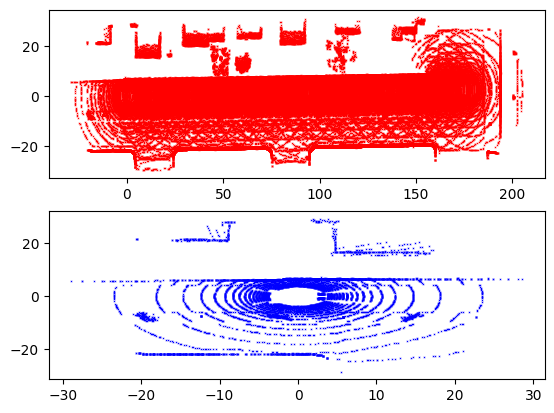

In [76]:
fig, (ax1,ax2) = plt.subplots(2,1)

plot_pcd(ax1, map_array, color="red", label="Target", marker='x',s=.10)
plot_pcd(ax2, pointcloud_array, color="blue", label="Source", marker='x',s=.10)

plt.show()

#### 3D Visualization of Point Clouds

To effectively analyze the 3D structure of the environment captured in PCD files, we'll use a Python function to render the point clouds in a 3D space. This visualization helps to have a grasp on how the pointcloud is structured. For this we will rely on the `open3d` library that has several tools to work with pointclouds in python. 

In [78]:
def show_pcl(pcl: np.ndarray):
    
    pointcloud = o3d.geometry.PointCloud()
    pointcloud.points = o3d.utility.Vector3dVector(pcl[:,:3])

    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pointcloud)
    
    opt = vis.get_render_option()
    opt.background_color = (0, 0, 0)
    opt.point_size = 2

    vis.run()
    vis.destroy_window()
    del opt  # Delete to avoid having  [Open3D ERROR] GLFW Error: The GLFW library is not initialized
    del vis  # Delete to avoid having  [Open3D ERROR] GLFW Error: The GLFW library is not initialized

In [6]:
# Example of how to visualize the map and a frame
#### Map Visualization
show_pcl(map_array)


In [7]:
#### Frame Visualization
show_pcl(pointcloud_array)

### Downsample poincloud

When analyzing the map and frame point clouds, it's evident that these data arrays consist of an immense number of individual points. This high density can significantly increase computation time and lead to unstable results during processing. To address these challenges, downsampling is an essential step in point cloud processing that aims to reduce the density of the points while maintaining the overall structural integrity.

#### Importance of Downsampling:

1. **Improved Computation Time:** High-density point clouds are computationally intensive, especially in tasks like registration (aligning point clouds). Downsampling simplifies the data, leading to faster processing.

2. **Stability in Analysis:** Excessive points may introduce noise and outliers into the data, resulting in inconsistent results. Downsampling can help filter out these unwanted elements, providing a more stable dataset for further analysis.

3. **Memory Efficiency:** Reducing point density lowers memory usage, making it feasible to handle larger datasets without overwhelming available system resources.

#### Voxelization

A particularly effective technique for downsampling is voxelization. This method involves dividing the 3D space into a grid of small, cube-like cells known as voxels. Each voxel represents several nearby points, reducing the overall count while preserving spatial relationships The key benefits of voxelization include:

1. **Reduced Data Size:** Each voxel represents multiple nearby points, effectively reducing the overall number of data points.
2. **Spatial Structure Retention:** Despite the reduction in data, the voxel grid preserves the original spatial relationships and geometries within the point cloud.

The following code demonstrates how to downsample a point cloud using `open3d`'s voxel grid utility.

In [79]:

def downsample_voxel(map_array: np.ndarray, voxel_size: float):
    """
    Downsamples a pointcloud using a voxel grid, and provides voxel configurations.

    Args:
    - map_pcd_arr (np.ndarray): Input point cloud as an Nx3 numpy array.
    - voxel_size (float): Desired voxel size for downsampling.

    Returns:
    - Tuple[np.ndarray, dict]: Downsampled point cloud as an Nx3 numpy array,
                               and a dictionary with voxel configuration details.
    """
    # Convert np array to open3D pointcloud
    map_pcd = o3d.geometry.PointCloud()
    map_pcd.points = o3d.utility.Vector3dVector(map_array)
    
    # Use open3D voxelisation utility with desired voxel_size
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(map_pcd, voxel_size)
    
    # Get coordinates of the voxels that are points of the downsampled grid
    indices = np.array([voxel.grid_index for voxel in voxel_grid.get_voxels()], dtype=float) * voxel_size

    # Calculate voxel configuration details
    max_bound = voxel_grid.get_max_bound()
    min_bound = voxel_grid.get_min_bound()
    voxel_config = {
        'voxel_bounds': {'min': 0, 'max': indices.max(axis=0)},
        'real_bounds': {'min': min_bound, 'max': max_bound}
    }

    # Adjust indices to represent real-world coordinates (center of each voxel)
    indices += min_bound + voxel_size / 2

    return indices, voxel_config


Let's examine the effects of downsampling the map at different voxel sizes. We will compare the original map with maps downsampled using two voxel sizes: `0.5` and `0.25`. This will illustrate how voxelization can reduce point cloud density while preserving spatial information.

Point Cloud Sizes:
Original shape = (143949, 3)
Voxel size = 0.25 -> Downsampled shape = (106740, 3)
Voxel size = 0.5 -> Downsampled shape = (44029, 3)


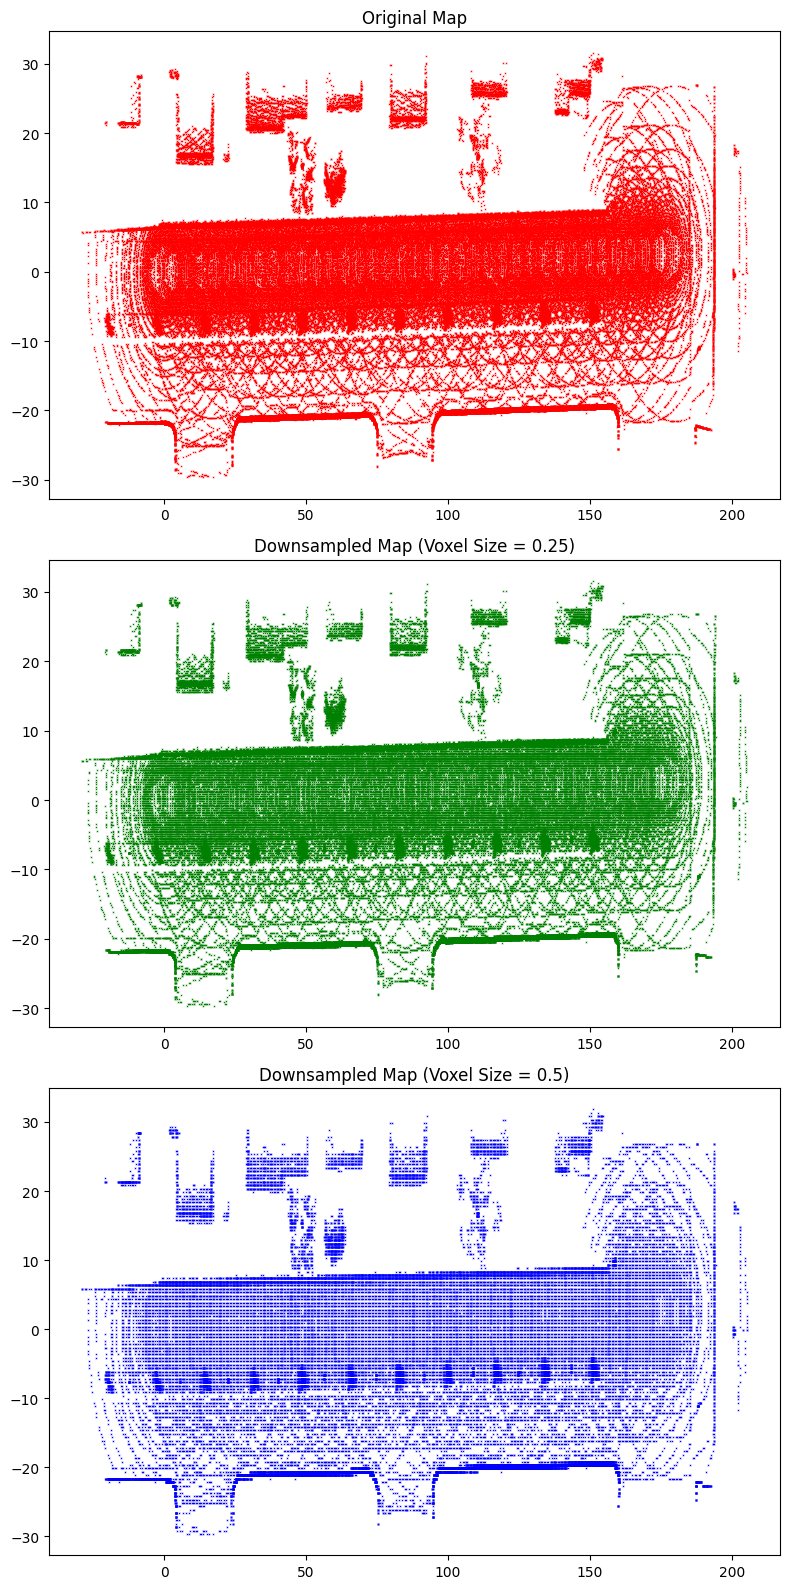

In [27]:
voxel_size = 0.5

# Downsample the point cloud for different purposes
voxel_map_0_5, voxel_config_show = downsample_voxel(map_array, voxel_size=voxel_size)  # Better for plotting purposes
voxel_map_0_25, voxel_config = downsample_voxel(map_array, voxel_size=voxel_size / 2)  # Good for ICP

# Print sizes of the original and downsampled point clouds
print("Point Cloud Sizes:")
print(f"Original shape = {map_array.shape}")
print(f"Voxel size = {voxel_size / 2} -> Downsampled shape = {voxel_map_0_25.shape}")
print(f"Voxel size = {voxel_size} -> Downsampled shape = {voxel_map_0_5.shape}")

# Plot the original and downsampled maps
fig, axs = plt.subplots(3, 1, figsize=(8, 16))

# Plot the original map
axs[0].set_title("Original Map")
plot_pcd(axs[0], map_array, color="red", label="Original", marker='x', s=0.10)

# Plot the map downsampled at voxel_size/2
axs[1].set_title(f"Downsampled Map (Voxel Size = {voxel_size / 2})")
plot_pcd(axs[1], voxel_map_0_25, color="green", label="Downsampled (0.25)", marker='x', s=0.10)

# Plot the map downsampled at voxel_size
axs[2].set_title(f"Downsampled Map (Voxel Size = {voxel_size})")
plot_pcd(axs[2], voxel_map_0_5, color="blue", label="Downsampled (0.5)", marker='x', s=0.10)


plt.tight_layout()
plt.show()


Now Let's examine the effects of downsampling the frame at different voxel sizes.

Point Cloud Sizes:
Original shape = (143949, 3)
Voxel size = 0.25 -> Downsampled shape = (106740, 3)
Voxel size = 0.5 -> Downsampled shape = (2715, 3)


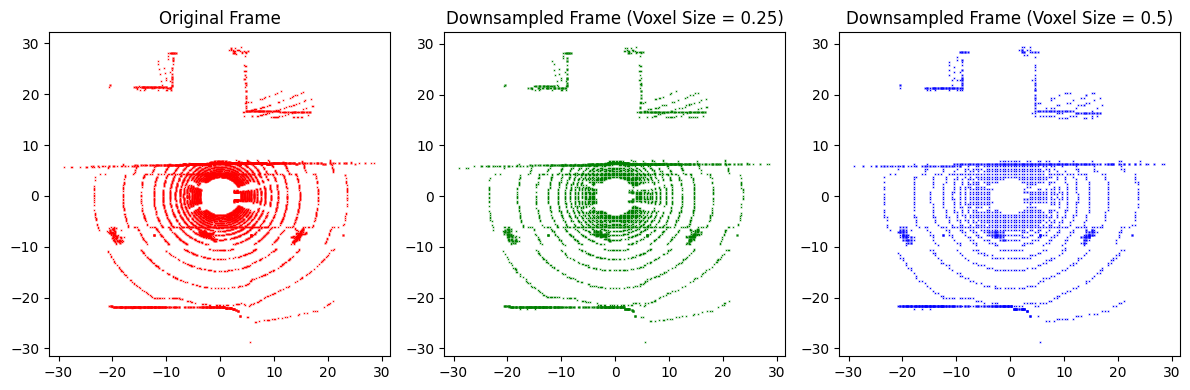

In [80]:
voxel_size = 0.5

# Downsample the point cloud for different purposes
voxel_frame_0_5, voxel_config_show = downsample_voxel(pointcloud_array, voxel_size=voxel_size)  # Better for plotting purposes
voxel_frame_0_25, voxel_config = downsample_voxel(pointcloud_array, voxel_size=voxel_size / 2)  # Good for ICP

# Print sizes of the original and downsampled point clouds
print("Point Cloud Sizes:")
print(f"Original shape = {map_array.shape}")
print(f"Voxel size = {voxel_size / 2} -> Downsampled shape = {voxel_map_0_25.shape}")
print(f"Voxel size = {voxel_size} -> Downsampled shape = {voxel_map_0_5.shape}")

# Plot the original and downsampled maps
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the original map
axs[0].set_title("Original Frame")
plot_pcd(axs[0], pointcloud_array, color="red", label="Original", marker='x', s=0.10)

# Plot the map downsampled at voxel_size/2
axs[1].set_title(f"Downsampled Frame (Voxel Size = {voxel_size / 2})")
plot_pcd(axs[1], voxel_frame_0_25, color="green", label="Downsampled (0.25)", marker='x', s=0.10)

# Plot the map downsampled at voxel_size
axs[2].set_title(f"Downsampled Frame (Voxel Size = {voxel_size})")
plot_pcd(axs[2], voxel_frame_0_5, color="blue", label="Downsampled (0.5)", marker='x', s=0.10)


plt.tight_layout()
plt.show()

#### Symplifying further the poincloud to retain only boundaries

In general, the NDT (Normal Distributions Transform) algorithm presented in [Example](../Examples/NDT_localization.ipynb) is designed for 2D localization, as the calculated Jacobians and Hessians assume a **2D** space. The grids used are also 2D, leading to distributions suitable for two-dimensional mapping. However, similar derivations can be applied to achieve the equations required for a **3D** space.

A beneficial approach to improve the efficiency of both NDT and ICP is to simplify point clouds by retaining only their boundaries. This can be achieved using `open3d` to extract boundaries from the point clouds, as shown in the function below:

In [61]:
def boundaries(map_array: np.ndarray, r: float = 2.5, n_iter: int = 2000, zlims: Tuple[float, float] = (-1, 7), device_str: str = "CPU:0") -> np.ndarray:
    """
    Detects boundaries in a voxelized point cloud and trims the results within specified z-limits.

    Args:
    - map_array (np.ndarray): Voxelized point cloud, shape (Nr_points, 3).
    - r (float): Radius to consider points as part of the same object.
    - n_iter (int): Number of iterations for edge detection.
    - zlims (Tuple[float, float]): Minimum and maximum z-values to consider.
    - device_str (str): Device identifier for computation.

    Returns:
    - np.ndarray: Point cloud containing detected boundaries, shape (Nr_points_downsampled, 3).
    """
    # Set up the computation device and data type
    device = o3d.core.Device(device_str)
    dtype = o3d.core.Dtype.Float32

    # Initialize an empty point cloud on the specified device
    tensor_map = o3d.t.geometry.PointCloud(device)

    # Assign data to point cloud
    tensor_map.point['positions'] = o3d.core.Tensor(map_array, dtype, device)

    # Estimate normals for the point cloud
    tensor_map.estimate_normals()

    # Calculate the boundaries of the point cloud using the provided radius and iterations
    boundaries, _ = tensor_map.compute_boundary_points(r, n_iter)

    # Extract the boundary points as a NumPy array
    np_boundaries = boundaries.point['positions'].numpy()

    # Apply z-limits to filter the point cloud
    z_filter = (np_boundaries[:, 2] > zlims[0]) & (np_boundaries[:, 2] < zlims[1])
    np_boundaries = np_boundaries[z_filter]

    return np_boundaries

**Example for Map**

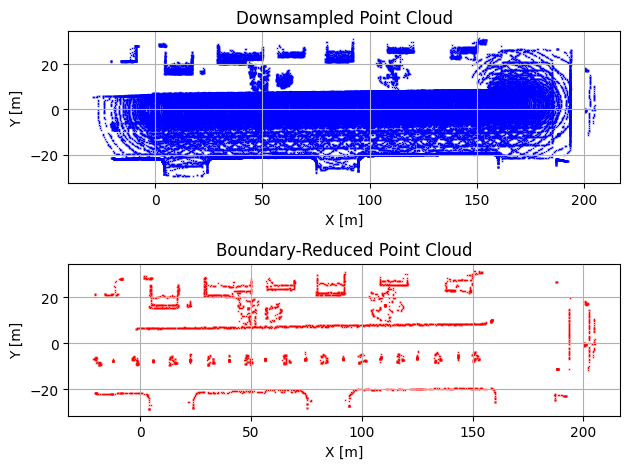

In [68]:
voxel_size = 0.25
r = 2.5
zlims = [0, 7]

# Downsample the point cloud for plotting purposes
voxel_map, voxel_config_show = downsample_voxel(map_array, voxel_size=voxel_size)

# Filter to create a boundary-reduced map
bounded_map = boundaries(voxel_map, r=r, zlims=zlims)

# Plot both the downsampled and boundary-reduced maps
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plot the downsampled map
ax1.set_title("Downsampled Point Cloud")
plot_pcd(ax1, voxel_map, color="blue", label="Downsampled Map", marker='x', s=0.10)
ax1.set_ylabel("Y [m]")
ax1.set_xlabel("X [m]")
ax1.grid()

# Plot the boundary-reduced map
ax2.set_title("Boundary-Reduced Point Cloud")
plot_pcd(ax2, bounded_map, color="red", label="Boundary-Reduced Map", marker='x', s=0.10)
ax2.set_ylabel("Y [m]")
ax2.set_xlabel("X [m]")
ax2.grid()

plt.tight_layout()
plt.show()

**Example for frame**

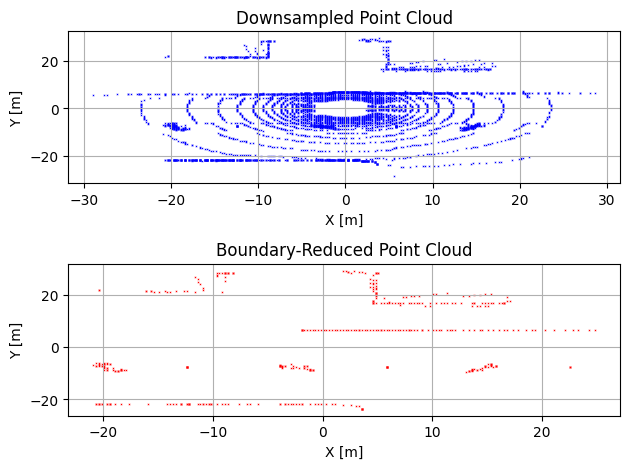

In [70]:
voxel_size = 0.25
r = 2.5
zlims = [0, 7]

# Downsample the point cloud for plotting purposes
voxel_frame, voxel_config_show = downsample_voxel(pointcloud_array, voxel_size=voxel_size)

# Filter to create a boundary-reduced map
bounded_frame = boundaries(voxel_frame, r=r, zlims=zlims)

# Plot both the downsampled and boundary-reduced maps
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plot the downsampled map
ax1.set_title("Downsampled Point Cloud")
plot_pcd(ax1, voxel_frame, color="blue", label="Downsampled Frame", marker='x', s=0.10)
ax1.set_ylabel("Y [m]")
ax1.set_xlabel("X [m]")
ax1.grid()

# Plot the boundary-reduced map
ax2.set_title("Boundary-Reduced Point Cloud")
plot_pcd(ax2, bounded_frame, color="red", label="Boundary-Reduced Frame", marker='x', s=0.10)
ax2.set_ylabel("Y [m]")
ax2.set_xlabel("X [m]")
ax2.grid()

plt.tight_layout()
plt.show()

### Further simplifications

If you're encountering challenges with the NDT algorithm, here are some practical suggestions to consider, especially if you aim to use the 2D formulation:

1. **Convert the Map and frame to 2D:** Since the vehicle primarily moves on a flat road, you can simplify the point cloud data by working in 2D. Ground truth data indicates that variations in the z-coordinate, roll, and pitch are minimal. Thus, you can:

    - **Filter Ground Points:** Remove points representing the road surface since they contribute little unique mapping information.
    - **Limit Maximum Height:** Set a reasonable height limit to focus on features relevant to the vehicle's navigation.
    - **Use X and Y Coordinates Only:** For both the map and frame, retain only the X and Y coordinates, setting the z-coordinate to zero.

By reducing the data to a 2D map, the NDT algorithm becomes more computationally efficient and easier to handle. Additionally, this simplification helps to identify relevant landmarks for accurate localization, making the process more robust and reliable.